##### Họ và tên : Nguyễn Thành Luân
##### MSSV: 20521582

In [12]:
import numpy as np
import pandas as pd 
import re

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

Đọc file

In [3]:
data = pd.read_csv('titanic.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     1309 non-null   int64  
 1   Survived   1309 non-null   int64  
 2   Name       1309 non-null   object 
 3   Sex        1309 non-null   object 
 4   Age        1046 non-null   float64
 5   SibSp      1309 non-null   int64  
 6   Parch      1309 non-null   int64  
 7   Ticket     1309 non-null   object 
 8   Fare       1308 non-null   float64
 9   Cabin      295 non-null    object 
 10  Embarked   1307 non-null   object 
 11  Boat       486 non-null    object 
 12  Body       121 non-null    float64
 13  Home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [6]:
data.describe()

,Pclass,Survived,Age,SibSp,Parch,Fare,Body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [7]:
data.isnull().sum()

Pclass          0
Survived        0
Name            0
Sex             0
Age           263
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin        1014
Embarked        2
Boat          823
Body         1188
Home.dest     564
dtype: int64

In [9]:
data['Survived'].value_counts()

Survived
0    809
1    500
Name: count, dtype: int64

#### Thống kê số người đi cùng (anh chị em/vợ chồng hoặc cha mẹ/con cái)

In [11]:
for dataset in [data]:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['Relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
data['not_alone'].value_counts()

not_alone
1    790
0    519
Name: count, dtype: int64

#### Tiền xử lý dữ liệu

In [14]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in [data]:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
data = data.drop(['Cabin'], axis=1)

#### Xem xét thuộc tính ticket 

In [15]:
data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

#### Thực hiện xóa các thuộc tính không cần thiết

In [16]:
data = data.drop(['Ticket'], axis=1)
data = data.drop(['Boat'], axis=1)
data = data.drop(['Body'], axis=1)
data = data.drop(['Home.dest'], axis=1)

#### Điền giá trị còn thiếu vào thuộc tính tuổi (age)
#### Các giá tri này sẽ được sinh ngẫu nhiên dựa vào giá trị trung bình, độ lệch chuẩn và số các giá trị còn thiếu

In [17]:
for dataset in [data]:
    mean = data['Age'].mean()
    std = data['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = data['Age'].astype(int)
data['Age'].isnull().sum()

0

In [18]:
data['Embarked'].describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

#### Ta thấy, giá trị 'S' là phổ biến nhất, nên có thể chọn nó điền vào các vị trí còn trống

In [19]:
common_value = 'S'

for dataset in [data]:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

#### Đối với thuộc tính giá vé

In [20]:
for dataset in [data]:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Xem xét lại các thuộc tính

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pclass     1309 non-null   int64 
 1   Survived   1309 non-null   int64 
 2   Name       1309 non-null   object
 3   Sex        1309 non-null   object
 4   Age        1309 non-null   int32 
 5   SibSp      1309 non-null   int64 
 6   Parch      1309 non-null   int64 
 7   Fare       1309 non-null   int32 
 8   Embarked   1309 non-null   object
 9   Relatives  1309 non-null   int64 
 10  not_alone  1309 non-null   int32 
 11  Deck       1309 non-null   int32 
dtypes: int32(4), int64(5), object(3)
memory usage: 102.4+ KB


#### Đối với thuộc tính tên (name), có thể sẽ trích xuất danh hiệu (title) từ thuộc tính này để xây dựng thuộc tính mới

In [25]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in [data]:
    #extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr',\
                                                'Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)
data = data.drop(['Name'], axis=1)

#### Biểu diễn thuộc tính giới tính (sex) thành các giá trị 0 (nam), 1 (nữ)

In [26]:
genders = {"male" : 0, "female": 1}

for dataset in [data]:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Chuyển đổi thuộc tính cổng lên tàu (embarked) thành số

In [27]:
ports = {"S":0, "C": 1, "Q":2}

for dataset in [data]:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### Chia giá trị tuổi thành 8 nhóm nhỏ có số lượng hành khách tương đối đều nhau

In [28]:
for dataset in [data]:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age']<=11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <=18),'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <=22),'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <=27),'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <=33),'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <=40),'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <=66),'Age'] = 6
    dataset.loc[dataset['Age'] > 66,'Age'] = 7

#### Chia giá trị vé thành 6 nhóm nhỏ có số lượng hành khách tương đối đều nhau

In [29]:
for dataset in [data]:
    dataset.loc[  dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ (dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare'] = 3
    dataset.loc[ (dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare'] = 4
    dataset.loc[  dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Tạo thuộc tính tuổi * loại vé (age_class)

In [30]:
for dataset in [data]:
    dataset['Age_class'] = dataset['Age'] * dataset['Pclass']

#### Tạo thuộc tính giá vé trên mỗi người (fare_per_person)

In [31]:
for dataset in [data]:
    dataset['Fare_per_person'] = dataset['Fare']/(dataset['Relatives']+1)
    dataset['Fare_per_person'] = dataset['Fare_per_person'].astype(int)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Pclass           1309 non-null   int64
 1   Survived         1309 non-null   int64
 2   Sex              1309 non-null   int64
 3   Age              1309 non-null   int32
 4   SibSp            1309 non-null   int64
 5   Parch            1309 non-null   int64
 6   Fare             1309 non-null   int32
 7   Embarked         1309 non-null   int64
 8   Relatives        1309 non-null   int64
 9   not_alone        1309 non-null   int32
 10  Deck             1309 non-null   int32
 11  Title            1309 non-null   int64
 12  Age_class        1309 non-null   int64
 13  Fare_per_person  1309 non-null   int32
dtypes: int32(5), int64(9)
memory usage: 117.7 KB


In [34]:
data.head(10)

,Pclass,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Relatives,not_alone,Deck,Title,Age_class,Fare_per_person
0,1,1,1,4,0,0,4,0,0,1,2,2,4,4
1,1,1,0,0,1,2,4,0,3,0,3,4,0,1
2,1,0,1,0,1,2,4,0,3,0,3,2,0,1
3,1,0,0,4,1,2,4,0,3,0,3,1,4,1
4,1,0,1,3,1,2,4,0,3,0,3,3,3,1
5,1,1,0,6,0,0,2,0,0,1,5,1,6,2
6,1,1,1,6,1,0,3,0,1,0,4,2,6,1
7,1,0,0,5,0,0,0,0,0,1,1,1,5,0
8,1,1,1,6,2,0,3,0,2,0,3,3,6,1
9,1,0,0,7,0,0,3,1,0,1,8,1,7,3


#### Sử dụng KMeans

In [35]:
Y = data['Survived']
X = data.drop(['Survived'], axis=1).iloc[: , :].values
inertia = []
for n in range(1, 11):
    algorithm = KMeans(n_clusters = n, init='random')
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

c:\Users\THANH LUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\THANH LUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\THANH LUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\THANH LUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

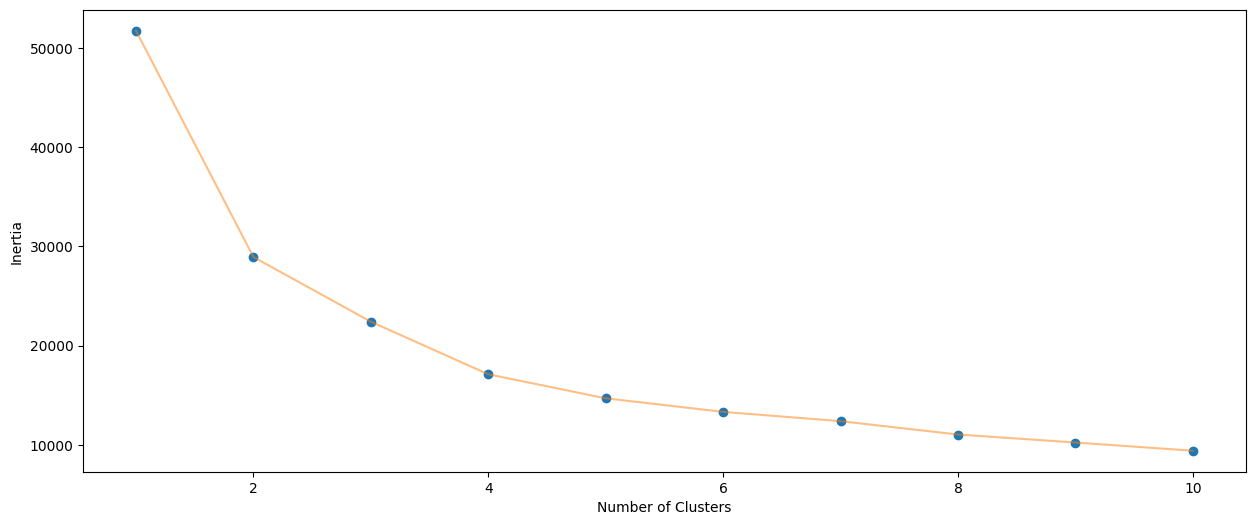

In [38]:
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

In [39]:
algorithm = KMeans(n_clusters=2, init='random')
algorithm.fit(X)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_

c:\Users\THANH LUAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [42]:
cm = confusion_matrix(Y, labels)

precision = precision_score(Y, labels)
recall = recall_score(Y, labels)
f1 = f1_score(Y, labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(cm)

Precision: 0.24677716390423574
Recall: 0.268
F1-score: 0.2569511025886865
Confusion Matrix:
[[400 409]
 [366 134]]
